In [ ]:
!pip install pyod

In [4]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
from scipy.stats import chi2
from scipy.stats import multivariate_normal
from sklearn.datasets import make_spd_matrix;
import copy

# algorithms
from pyod.models.ocsvm import OCSVM
from pyod.models.lof import LOF
from pyod.models.pca import PCA
from pyod.models.iforest import IForest

# evaluation

from sklearn.model_selection import train_test_split;
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [5]:
def split_data(df):
  X = df.loc[:, df.columns != "Label"]
  y= df["Label"]
  x_train , x_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.30)
  return x_train , x_test, y_train, y_test

In [6]:
def train_test_eval( y_train, y_test,y_train_pred,y_test_pred ):
  tr_prec = precision_score(y_train, y_train_pred, average='weighted')
  tr_rec = recall_score(y_train, y_train_pred, average='weighted')
  tr_acc = accuracy_score(y_train, y_train_pred, normalize=True);
  tr_f1 = f1_score(y_train, y_train_pred, average='weighted')

  tst_prec = precision_score(y_test, y_test_pred, average='weighted')
  tst_rec = recall_score(y_test, y_test_pred, average='weighted')
  tst_acc = accuracy_score(y_test, y_test_pred, normalize=True);
  tst_f1 = f1_score(y_test, y_test_pred, average='weighted')

  return tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1

In [7]:
#@jit(target_backend='cuda') 
def apply_anomaly_detection(x_train ,  x_test , clf):
  clf.fit(x_train.values)
  y_train_pred = clf.predict(x_train.values)
  y_test_pred = clf.predict(x_test.values) 
  #print('a')
  return y_train_pred,y_test_pred

In [8]:
def mu_vector( n_features, low_range, high_range):
    """
    This function is used to generate the mean vector for various
    Gaussians in GMM
    """
    #print("mu_vector")
    mu_set = set()
    while(len(mu_set) < n_features):
      mu_set.add(random.randint(low_range, high_range))
    #mu_vector_lst.append(mu_set)
    return list(mu_set);

In [9]:
def mahalanobis(x=None, data=None, cov=None):
    print("mahalanobis")
    x_mu = x - np.mean(data)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)

    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

In [10]:
def label_outliers(cont_fact, mu, df, cov_m , n_features):
  print("label_outliers")
  df = df;
  #df['p'] = chi2.cdf(df['distance'], n_features-1)
  #print("before sorting")
  #print(df)
  #df = df.sort_values('p')
  #print("after sorting")
  #print(df)
  # sort according to p-values
  #n_outliers = int((cont_fact * len(df) ));
  #print(n_outliers);
  #df['flag'] = df.index.isin(df.p.nlargest(n_outliers).index).astype(int)
  #df['Label'] =  np.where(df['p'] < cont_fact, 1, 0)
  #df = df.sort_values('p')
  #outliers = int(len(data)* cont_fact);
  #df['Label'] = 0;
  #df['Label'].iloc[0:n_outliers] = 1;
  #df = df.drop(['distance', 'p'], axis=1)
  llim, ulim = chi2.ppf([cont_fact/2 , 1-(cont_fact/2)], n_features-1, loc=0, scale=1);
  df['Label'] = np.where((df['distance'] < llim)|(df['distance'] > ulim), 1, 0);
  df = df.drop(['distance'], axis=1)
  in_dst = df.loc[df['Label'] == 0]
  out_dst = df.loc[df['Label'] == 1]
  print("Inlier percent", len(in_dst)/len(df))
  print("Outlier percent", len(out_dst)/len(df))
  print("///////////////////////////////")

  return df

In [11]:
def label_outliers_try(cont_fact, df):
  #print("label_outliers")
  df = df;
  n_features = len(df.columns)
  #df['p'] = chi2.cdf(df['distance'], n_features-1)
  #print("before sorting")
  #print(df)
  #df = df.sort_values('p')
  #print("after sorting")
  #print(df)
  # sort according to p-values
  #n_outliers = int((cont_fact * len(df) ));
  #print(n_outliers);
  #df['flag'] = df.index.isin(df.p.nlargest(n_outliers).index).astype(int)
  #df['Label'] =  np.where(df['p'] < cont_fact, 1, 0)
  #df = df.sort_values('p')
  #outliers = int(len(data)* cont_fact);
  #df['Label'] = 0;
  #df['Label'].iloc[0:n_outliers] = 1;
  #df = df.drop(['distance', 'p'], axis=1)
  llim, ulim = chi2.ppf([cont_fact/2 , 1-(cont_fact/2)], n_features-1, loc=0, scale=1);
  df['Label'] = np.where((df['distance'] < llim)|(df['distance'] > ulim), 1, 0);
  df = df.drop(['distance'], axis=1)
  in_dst = df.loc[df['Label'] == 0]
  out_dst = df.loc[df['Label'] == 1]
  print("Inlier percent", len(in_dst)/len(df))
  print("Outlier percent", len(out_dst)/len(df))
  print("///////////////////////////////")

  return df

In [12]:
def generate_dataset():
  #print("generate_dataset")
  # find number of feature
  n_features = random.randint(2, 10);
  print("n_features",n_features)
  # find mu vector
  mu_low = random.randint(2, 20);
  mu_high = random.randint(20, 40);
  mu = mu_vector(n_features, mu_low, mu_high)
  # find covariance matrix
  cov_m = make_spd_matrix(n_features);
  # pass to mvn data generator
  mvn_rvs = multivariate_normal.rvs(mean=mu, cov=cov_m, size=10000, random_state=None)
  col_list =[]
  for i in range(n_features):
    col_nm = 'X_'+ str(i);
    col_list.append(col_nm);
  df = pd.DataFrame(mvn_rvs, columns=col_list )
  df['distance'] = mahalanobis(x = df , data = df , cov=cov_m)
  #print(df)
  # find mahalanobis distance, find p value, label outlier
  #df = label_outliers(cont_fact, mu, df,cov_m , n_features)
  # return
  return df 

# generated datasets

In [ ]:
df_list = []


In [ ]:
for i in range(7):
  print(i)
  temp_df = generate_dataset()
  df_list.append(temp_df)


In [36]:
len(df_list)

100

In [10]:
df = generate_dataset(0.05)

generate_dataset
n_features 7
label_outliers
mahalanobis
Inlier percent 0.9461
Outlier percent 0.0539
///////////////////////////////


In [ ]:
df['distance']

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

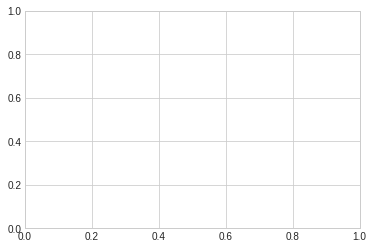

In [13]:
fig = plt.figure()
ax = plt.axes()

# plot chi2 distribution

# 1. Contamination Factor

In [65]:
cont_factor = np.arange(0.02,0.12,0.02)

col_list =[]
met = ['Pr', 'Re', 'Ac', 'F1']
for j in met:
  col_list.append("Tr_"+j)
  col_list.append("Te_"+j)
col_list

df_name_lst = []
for i in cont_factor:
  df_name = "Eval_"+str(round(i,2));
  df_name_lst.append(df_name);
print(df_name_lst)

['Eval_0.02', 'Eval_0.04', 'Eval_0.06', 'Eval_0.08', 'Eval_0.1']


## 1.1 LOF
(http://ianmadd.github.io/pages/Confidence_Intervals_Part4.html)

In [ ]:
df_dict_cont_LOF = { name : pd.DataFrame(columns = col_list) for name in df_name_lst}
for i in cont_factor:
  print( "i and j ", i )
  #key_name = 'Tr_'+ str(i) +"_"
  #lst_name = str(i)+"_lst"
  df_name = "Eval_"+str(round(i,2))
  lst_name = []
  clf = LOF(contamination = i);
  df_all = copy.deepcopy(df_list);
  for j in df_all:
    #print( "i and j ", i , j)
    temp_lst = []
    df = j;
    # label outliers
    df_label = label_outliers_try(i, df);
    #df = label_expon_outliers( i , X );
    x_train , x_test, y_train, y_test = split_data(df_label);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    lst_name.append(temp_lst); 

  df_dict_cont_LOF[df_name] = pd.DataFrame(lst_name, columns=col_list)
  #print(lst_name);
  #print(df_dict_cont_LOF[df_name])
  #df_dict_OCSVM[df_name].append(lst_name); 
  #df_dict__cont_OCSVM_temp[df_name] = lst_name;
  #print(df_dict_OCSVM)
#print(lst_name)

#print(len(lst_name))


In [41]:
# Enumerate over he datafrmes in dictionary and store in excel files
for key in df_dict_cont_LOF:
  sheet_name = "Cont_Fact_LOF_"+key;
  df = df_dict_cont_LOF[key];
  #print(df)  
  # write to excel 
  filename = "Cont_Fact_LOF_"+sheet_name+".xlsx";
  df.to_excel(filename, sheet_name=key)

In [42]:
df_dict_cont_LOF['Eval_0.02']

,Tr_Pr,Te_Pr,Tr_Re,Te_Re,Tr_Ac,Te_Ac,Tr_F1,Te_F1
0,0.977821,0.977728,0.978714,0.977333,0.978714,0.977333,0.978253,0.977528
1,0.977055,0.977091,0.979143,0.975000,0.979143,0.975000,0.977972,0.975980
2,0.977699,0.977494,0.979714,0.974000,0.979714,0.974000,0.978575,0.975585
3,0.976904,0.974451,0.978429,0.972667,0.978429,0.972667,0.977620,0.973530
4,0.978192,0.976626,0.980714,0.977333,0.980714,0.977333,0.979180,0.976969
...,...,...,...,...,...,...,...,...
95,0.976416,0.970786,0.978286,0.972333,0.978286,0.972333,0.977261,0.971536
96,0.980274,0.983813,0.980857,0.983667,0.980857,0.983667,0.980556,0.983739
97,0.979919,0.976935,0.980857,0.975333,0.980857,0.975333,0.980359,0.976100
98,0.975123,0.978572,0.977000,0.977667,0.977000,0.977667,0.975998,0.978104


In [43]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
var_result_cols = ['cont_fact', 'Train_Pr_var', 'Test_Pr_var', 'Train_Re_var', 'Test_Re_var', 'Train_Acc_var', 'Test_Acc_var', 'Train_F1_var','Test_F1_var'];
lof_cont_results_mean = pd.DataFrame(columns = mu_result_cols)
lof_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [44]:
for val in df_dict_cont_LOF.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    

lof_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [45]:
lof_cont_results_mean

,cont_fact,Train_Pr_mu,Test_Pr_mu,Train_Re_mu,Test_Re_mu,Train_Acc_mu,Test_Acc_mu,Train_F1_mu,Test_F1_mu
0,0.02,0.977414,0.976581,0.979199,0.976250,0.979199,0.976250,0.978199,0.976361
1,0.04,0.955360,0.953573,0.958477,0.952723,0.958477,0.952723,0.956761,0.953098
2,0.06,0.934637,0.931869,0.938599,0.930587,0.938599,0.930587,0.936432,0.931157
3,0.08,0.914098,0.909779,0.918616,0.907883,0.918616,0.907883,0.916155,0.908751
4,0.10,0.893375,0.888264,0.898586,0.885290,0.898586,0.885290,0.895753,0.886680


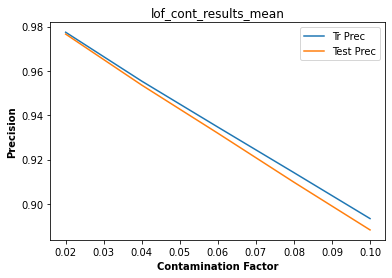

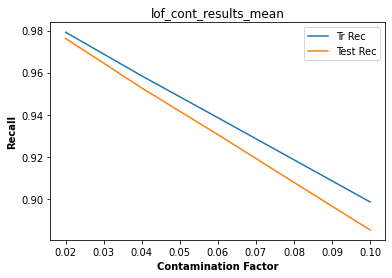

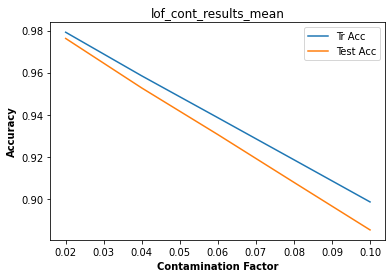

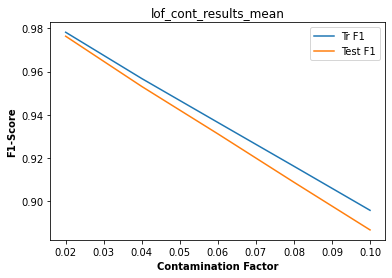

In [46]:
plt.title("lof_cont_results_mean")
plt.plot(lof_cont_results_mean['cont_fact'], lof_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_pr.png', bbox_inches='tight')
plt.show()

plt.title("lof_cont_results_mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_re.png', bbox_inches='tight')
plt.show()


plt.title("lof_cont_results_mean")
plt.plot( lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_acc.png', bbox_inches='tight')
plt.show()


plt.title("lof_cont_results_mean")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(lof_cont_results_mean['cont_fact'],lof_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('lof_cont_results_mean_f1.png', bbox_inches='tight')
plt.show()

## 1.2 PCA

In [ ]:
df_dict_cont_PCA = { name : pd.DataFrame(columns = col_list) for name in df_name_lst}
for i in cont_factor:
  print( "i and j ", i )
  #key_name = 'Tr_'+ str(i) +"_"
  #lst_name = str(i)+"_lst"
  df_name = "Eval_"+str(round(i,2))
  lst_name = []
  clf = PCA(contamination = i);
  df_all = copy.deepcopy(df_list);
  for j in df_all:
    #print( "i and j ", i , j)
    temp_lst = []
    df = j;
    # label outliers
    df_label = label_outliers_try(i, df);
    #df = label_expon_outliers( i , X );
    num_comp = int((len(df_label.columns)-1)/2);
    clf.n_components = num_comp;
    x_train , x_test, y_train, y_test = split_data(df_label);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    lst_name.append(temp_lst);

  df_dict_cont_PCA[df_name] = pd.DataFrame(lst_name, columns=col_list)


In [48]:
# Enumerate over he datafrmes in dictionary and store in excel files
for key in df_dict_cont_PCA:
  sheet_name = "Cont_Fact_PCA_"+key;
  df = df_dict_cont_PCA[key];
  #print(df) 
  # write to excel 
  filename = "Cont_Fact_PCA_"+sheet_name+".xlsx";
  df.to_excel(filename, sheet_name=key)

In [ ]:
df_dict_cont_PCA['Eval_0.02']

In [50]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
var_result_cols = ['cont_fact', 'Train_Pr_var', 'Test_Pr_var', 'Train_Re_var', 'Test_Re_var', 'Train_Acc_var', 'Test_Acc_var', 'Train_F1_var','Test_F1_var'];
pca_cont_results_mean = pd.DataFrame(columns = mu_result_cols)
pca_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [51]:
for val in df_dict_cont_PCA.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    

pca_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [ ]:
pca_cont_results_mean

In [ ]:
plt.title("pca_cont_results_mean")
plt.plot(pca_cont_results_mean['cont_fact'], pca_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('pca_cont_results_mean_pr.png', bbox_inches='tight')
plt.show()

plt.title("pca_cont_results_mean")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('pca_cont_results_mean_re.png', bbox_inches='tight')
plt.show()


plt.title("pca_cont_results_mean")
plt.plot( pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('pca_cont_results_mean_acc.png', bbox_inches='tight')
plt.show()


plt.title("pca_cont_results_mean")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(pca_cont_results_mean['cont_fact'],pca_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('pca_cont_results_mean_f1.png', bbox_inches='tight')
plt.show()

## 1.3 Isolation Forest

In [ ]:
df_dict_cont_if = { name : pd.DataFrame(columns = col_list) for name in df_name_lst}
for i in cont_factor:
  #key_name = 'Tr_'+ str(i) +"_"
  #lst_name = str(i)+"_lst"
  df_name = "Eval_"+str(round(i,2))
  lst_name = []
  clf = IForest(contamination = i);
  df_all = copy.deepcopy(df_list);
  for j in df_all:
    #print( "i and j ", i , j)
    temp_lst = []
    df = j;
    # label outliers
    df_label = label_outliers_try(i, df);
    x_train , x_test, y_train, y_test = split_data(df_label);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    lst_name.append(temp_lst);

  df_dict_cont_if[df_name] = pd.DataFrame(lst_name, columns=col_list)


In [56]:
# Enumerate over he datafrmes in dictionary and store in excel files
for key in df_dict_cont_if:
  sheet_name = "Cont_Fact_IF_"+key;
  df = df_dict_cont_if[key];
  #print(df) 
  # write to excel 
  filename = "Cont_Fact_IF_"+sheet_name+".xlsx";
  df.to_excel(filename, sheet_name=key)

In [ ]:
df_dict_cont_if['Eval_0.02']

In [58]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
var_result_cols = ['cont_fact', 'Train_Pr_var', 'Test_Pr_var', 'Train_Re_var', 'Test_Re_var', 'Train_Acc_var', 'Test_Acc_var', 'Train_F1_var','Test_F1_var'];
if_cont_results_mean = pd.DataFrame(columns = mu_result_cols)
if_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [59]:
for val in df_dict_cont_if.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    

if_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [ ]:
if_cont_results_mean

In [ ]:
plt.title("if_cont_results_mean")
plt.plot(if_cont_results_mean['cont_fact'], if_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( if_cont_results_mean['cont_fact'],if_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('if_cont_results_mean_pr.png', bbox_inches='tight')
plt.show()

plt.title("if_cont_results_mean")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('if_cont_results_mean_re.png', bbox_inches='tight')
plt.show()


plt.title("if_cont_results_mean")
plt.plot( if_cont_results_mean['cont_fact'],if_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('if_cont_results_mean_acc.png', bbox_inches='tight')
plt.show()


plt.title("if_cont_results_mean")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(if_cont_results_mean['cont_fact'],if_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('if_cont_results_mean_f1.png', bbox_inches='tight')
plt.show()

## 1.4 OCSVM

In [ ]:
df_dict_cont_ocsvm = { name : pd.DataFrame(columns = col_list) for name in df_name_lst}
for i in cont_factor:
  #key_name = 'Tr_'+ str(i) +"_"
  #lst_name = str(i)+"_lst"
  df_name = "Eval_"+str(round(i,2))
  lst_name = []
  clf = OCSVM(contamination = i);
  df_all = copy.deepcopy(df_list);
  for j in df_all:
    temp_lst = []
    df = j;
    # label outliers
    df_label = label_outliers_try(i, df);
    x_train , x_test, y_train, y_test = split_data(df_label);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);
    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);

    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    lst_name.append(temp_lst);

  df_dict_cont_ocsvm[df_name] = pd.DataFrame(lst_name, columns=col_list)


In [63]:
# Enumerate over he datafrmes in dictionary and store in excel files
for key in df_dict_cont_ocsvm:
  sheet_name = "Cont_Fact_OCSVM_"+key;
  df = df_dict_cont_ocsvm[key];
  #print(df) 
  # write to excel 
  filename = "Cont_Fact_OCSVM_"+sheet_name+".xlsx";
  df.to_excel(filename, sheet_name=key)

In [ ]:
df_dict_cont_ocsvm['Eval_0.02']

In [68]:
mu_result_cols = [ 'cont_fact', 'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
var_result_cols = ['cont_fact', 'Train_Pr_var', 'Test_Pr_var', 'Train_Re_var', 'Test_Re_var', 'Train_Acc_var', 'Test_Acc_var', 'Train_F1_var','Test_F1_var'];
ocsvm_cont_results_mean = pd.DataFrame(columns = mu_result_cols)
ocsvm_cont_results_mean['cont_fact'] = cont_factor;
lst_mu = []

In [69]:
for val in df_dict_cont_ocsvm.values():
    Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = val.mean();
    #print(Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1)
    mu = [Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1];
    lst_mu.append(mu);
    

ocsvm_cont_results_mean[['Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu']]= lst_mu;

In [70]:
ocsvm_cont_results_mean

,cont_fact,Train_Pr_mu,Test_Pr_mu,Train_Re_mu,Test_Re_mu,Train_Acc_mu,Test_Acc_mu,Train_F1_mu,Test_F1_mu
0,0.02,0.971021,0.971291,0.971079,0.970890,0.971079,0.970890,0.971043,0.971055
1,0.04,0.947671,0.947548,0.947769,0.947447,0.947769,0.947447,0.947713,0.947447
2,0.06,0.926380,0.926922,0.926417,0.926000,0.926417,0.926000,0.926391,0.926405
3,0.08,0.906103,0.905500,0.906020,0.904977,0.906020,0.904977,0.906052,0.905182
4,0.10,0.885594,0.885157,0.885446,0.884510,0.885446,0.884510,0.885510,0.884776


In [ ]:
plt.title("ocsvm_cont_results_mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'], ocsvm_cont_results_mean['Train_Pr_mu'],  label = "Tr Prec")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Pr_mu'], label = "Test Prec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Precision', fontweight ='bold')
plt.legend()
plt.savefig('ocsvm_cont_results_mean_pr.png', bbox_inches='tight')
plt.show()

plt.title("ocsvm_cont_results_mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Re_mu'],  label = "Tr Rec")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Re_mu'],  label = "Test Rec")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Recall', fontweight ='bold')
plt.legend()
plt.savefig('ocsvm_cont_results_mean_re.png', bbox_inches='tight')
plt.show()


plt.title("ocsvm_cont_results_mean")
plt.plot( ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_Acc_mu'], label = "Tr Acc")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_Acc_mu'],  label = "Test Acc")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('Accuracy', fontweight ='bold')
plt.legend()
plt.savefig('ocsvm_cont_results_mean_acc.png', bbox_inches='tight')
plt.show()


plt.title("ocsvm_cont_results_mean")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Train_F1_mu'],  label = "Tr F1")
plt.plot(ocsvm_cont_results_mean['cont_fact'],ocsvm_cont_results_mean['Test_F1_mu'],  label = "Test F1")
plt.xlabel('Contamination Factor', fontweight ='bold')
plt.ylabel('F1-Score', fontweight ='bold')
plt.legend()
plt.savefig('ocsvm_cont_results_mean_f1.png', bbox_inches='tight')
plt.show()

# 2. Dependency

## 2.1 Dependent + IF

In [72]:
df_dict_dependent_IF = pd.DataFrame( columns = col_list)

In [73]:
df_dict_dependent_IF

,Tr_Pr,Te_Pr,Tr_Re,Te_Re,Tr_Ac,Te_Ac,Tr_F1,Te_F1


In [ ]:
df = copy.deepcopy(df_list);
lst_name = []
clf = IForest(contamination = 0.05, n_jobs=100);
for j in df:
    df_label = label_outliers_try(0.05, j);
    temp_lst = []
    x_train , x_test, y_train, y_test = split_data(df_label);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);

    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )
    #print(tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1)

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);


    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    print(temp_lst)
    lst_name.append(temp_lst);

In [76]:
df_dict_dependent_IF= pd.DataFrame(lst_name, columns=col_list)

In [ ]:
df_dict_dependent_IF

In [78]:
mu_result_cols = [  'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
mu = Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1

lst_mu = []
Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = df_dict_dependent_IF.mean(axis=0)
lst_mu.append(list(mu));


IF_Dependent_results_mean = pd.DataFrame(lst_mu, columns = mu_result_cols)


In [ ]:
IF_Dependent_results_mean

In [80]:
IF_Dependent_results_mean.to_excel("IF_Dependent_results_mean.xlsx");

## 2.2 Dependent + PCA

In [ ]:
#clf = PCA(contamination = 0.05, n_jobs=100);
df = copy.deepcopy(df_list);
lst_name = []
clf = PCA(contamination = 0.05);
for j in df:

    n_components = int((len(j.axes[1])-1)/2);
    clf.n_components = n_components;

    df_label = label_outliers_try(0.05, j);

    temp_lst = []
    x_train , x_test, y_train, y_test = split_data(df_label);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);

    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )
    #print(tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1)

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);


    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    #print(temp_lst)
    lst_name.append(temp_lst);

    #df_dict_dependent_IF.append(temp_lst)

In [82]:
df_dict_dependent_PCA= pd.DataFrame(lst_name, columns=col_list)

In [83]:
mu_result_cols = [  'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
mu = Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1

lst_mu = []
Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = df_dict_dependent_IF.mean(axis=0)
lst_mu.append(list(mu));


PCA_Dependent_results_mean = pd.DataFrame(lst_mu, columns = mu_result_cols);


In [84]:
PCA_Dependent_results_mean.to_excel("PCA_Dependent_results_mean.xlsx");

## 2.3 Dependent + OCSVM

In [85]:
df = copy.deepcopy(df_list);
lst_name = []
clf = OCSVM(contamination = 0.05);
for j in df:

    #n_components = int((len(j.axes[1])-1)/2);
    #clf.n_components = n_components;
    df_label = label_outliers_try(0.05, j);

    temp_lst = []
    x_train , x_test, y_train, y_test = split_data(df_label);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);

    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )
    #print(tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1)

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);


    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    #print(temp_lst)
    lst_name.append(temp_lst);

    #df_dict_dependent_IF.append(temp_lst)

Inlier percent 0.9502
Outlier percent 0.0498
///////////////////////////////
Inlier percent 0.9483
Outlier percent 0.0517
///////////////////////////////
Inlier percent 0.9473
Outlier percent 0.0527
///////////////////////////////
Inlier percent 0.9514
Outlier percent 0.0486
///////////////////////////////
Inlier percent 0.9494
Outlier percent 0.0506
///////////////////////////////
Inlier percent 0.948
Outlier percent 0.052
///////////////////////////////
Inlier percent 0.9498
Outlier percent 0.0502
///////////////////////////////
Inlier percent 0.9522
Outlier percent 0.0478
///////////////////////////////
Inlier percent 0.9493
Outlier percent 0.0507
///////////////////////////////
Inlier percent 0.9469
Outlier percent 0.0531
///////////////////////////////
Inlier percent 0.9518
Outlier percent 0.0482
///////////////////////////////
Inlier percent 0.9496
Outlier percent 0.0504
///////////////////////////////
Inlier percent 0.9487
Outlier percent 0.0513
///////////////////////////////
I

In [90]:
df_dict_dependent_OCSVM= pd.DataFrame(lst_name, columns=col_list)

In [91]:
mu_result_cols = [  'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
mu = Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1

lst_mu = []
Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = df_dict_dependent_IF.mean(axis=0)
lst_mu.append(list(mu));


OCSVM_Dependent_results_mean = pd.DataFrame(lst_mu, columns = mu_result_cols)


In [92]:
OCSVM_Dependent_results_mean.to_excel("OCSVM_Dependent_results_mean.xlsx");

## 2.4 Dependent + LOF

In [89]:
df = copy.deepcopy(df_list);
lst_name = []
clf = LOF(contamination = 0.05);
for j in df:
    df_label = label_outliers_try(0.05, j);
    temp_lst = []
    x_train , x_test, y_train, y_test = split_data(df_label);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);

    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )
    #print(tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1)

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);


    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    #print(temp_lst)
    lst_name.append(temp_lst);

    #df_dict_dependent_IF.append(temp_lst)

Inlier percent 0.9502
Outlier percent 0.0498
///////////////////////////////
Inlier percent 0.9483
Outlier percent 0.0517
///////////////////////////////
Inlier percent 0.9473
Outlier percent 0.0527
///////////////////////////////
Inlier percent 0.9514
Outlier percent 0.0486
///////////////////////////////
Inlier percent 0.9494
Outlier percent 0.0506
///////////////////////////////
Inlier percent 0.948
Outlier percent 0.052
///////////////////////////////
Inlier percent 0.9498
Outlier percent 0.0502
///////////////////////////////
Inlier percent 0.9522
Outlier percent 0.0478
///////////////////////////////
Inlier percent 0.9493
Outlier percent 0.0507
///////////////////////////////
Inlier percent 0.9469
Outlier percent 0.0531
///////////////////////////////
Inlier percent 0.9518
Outlier percent 0.0482
///////////////////////////////
Inlier percent 0.9496
Outlier percent 0.0504
///////////////////////////////
Inlier percent 0.9487
Outlier percent 0.0513
///////////////////////////////
I

In [93]:
df_dict_dependent_LOF= pd.DataFrame(lst_name, columns=col_list)

In [94]:
mu_result_cols = [  'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
mu = Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1

lst_mu = []
Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = df_dict_dependent_IF.mean(axis=0)
lst_mu.append(list(mu));

LOF_Dependent_results_mean = pd.DataFrame(lst_mu, columns = mu_result_cols)


In [95]:
LOF_Dependent_results_mean.to_excel("LOF_Dependent_results_mean.xlsx");

# 3. Independent

In [17]:
def make_non_diagonal_zero(cov_m,n_features ):
  new_cov_m = cov_m;
  for i in range(n_features):
    for j in range(n_features):
      if (i != j):
        new_cov_m[i][j] = 0
  #print(new_cov_m);
  return new_cov_m

In [18]:
def generate_indepedent_dataset():
  #print("generate_dataset")
  # find number of feature
  n_features = random.randint(2, 10);
  print("n_features",n_features)
  # find mu vector
  mu_low = random.randint(2, 20);
  mu_high = random.randint(20, 40);
  mu = mu_vector(n_features, mu_low, mu_high)
  # find covariance matrix
  cov_m = make_spd_matrix(n_features);
  cov_in = make_non_diagonal_zero(cov_m, n_features)
  # pass to mvn data generator
  mvn_rvs = multivariate_normal.rvs(mean=mu, cov=cov_in, size=10000, random_state=None)
  col_list =[]
  for i in range(n_features):
    col_nm = 'X_'+ str(i);
    col_list.append(col_nm);
  df = pd.DataFrame(mvn_rvs, columns=col_list )
  df['distance'] = mahalanobis(x = df , data = df , cov=cov_m)
  #print(df)
  # find mahalanobis distance, find p value, label outlier
  #df = label_outliers(cont_fact, mu, df,cov_m , n_features)
  # return
  return df 

In [20]:
lst_indep_dsets = []

In [ ]:
for i in range(6):
  print(i)
  df = generate_indepedent_dataset();
  lst_indep_dsets.append(df);

In [46]:
len(lst_indep_dsets)

100

label outliers in independent datasets

In [47]:
def label_outliers_try(cont_fact, df):
  #print("label_outliers")
  df = df;
  n_features = len(df.columns)
  #df['p'] = chi2.cdf(df['distance'], n_features-1)
  #print("before sorting")
  #print(df)
  #df = df.sort_values('p')
  #print("after sorting")
  #print(df)
  # sort according to p-values
  #n_outliers = int((cont_fact * len(df) ));
  #print(n_outliers);
  #df['flag'] = df.index.isin(df.p.nlargest(n_outliers).index).astype(int)
  #df['Label'] =  np.where(df['p'] < cont_fact, 1, 0)
  #df = df.sort_values('p')
  #outliers = int(len(data)* cont_fact);
  #df['Label'] = 0;
  #df['Label'].iloc[0:n_outliers] = 1;
  #df = df.drop(['distance', 'p'], axis=1)
  llim, ulim = chi2.ppf([cont_fact/2 , 1-(cont_fact/2)], n_features-1, loc=0, scale=1);
  df['Label'] = np.where((df['distance'] < llim)|(df['distance'] > ulim), 1, 0);
  df = df.drop(['distance'], axis=1)
  in_dst = df.loc[df['Label'] == 0]
  out_dst = df.loc[df['Label'] == 1]
  print("Inlier percent", len(in_dst)/len(df))
  print("Outlier percent", len(out_dst)/len(df))
  print("///////////////////////////////")

  return df

In [ ]:
df_labeled = []
for i in lst_indep_dsets:
  temp_df = label_outliers_try(0.05, i)
  df_labeled.append(temp_df)


In [56]:
df_labeled[0]

,X_0,X_1,X_2,X_3,X_4,Label
0,13.817710,16.885380,18.210427,22.518827,23.085948,0
1,12.293741,15.064978,17.676090,22.027573,23.580279,0
2,12.960640,19.246526,18.378725,22.295730,21.749989,0
3,12.862786,14.710116,15.577433,21.812499,23.893772,0
4,12.839405,17.330834,17.238240,21.729857,23.649711,0
...,...,...,...,...,...,...
9995,13.713845,17.552597,19.440845,20.933765,23.377542,0
9996,10.064200,15.609447,18.192778,21.961352,22.376971,0
9997,11.996412,17.921698,21.518130,22.647318,23.621570,0
9998,11.265346,17.404586,18.733904,22.216247,23.125627,0


## 3.1 Independent + IF

In [58]:
clf = IForest(contamination = 0.05, n_jobs=100);
df = copy.deepcopy(df_labeled);
lst_name = []
clf = IForest(contamination = 0.05, n_jobs=100);
for j in df:
    temp_lst = []
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);

    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )
    #print(tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1)

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);


    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    #print(temp_lst)
    lst_name.append(temp_lst);

    #df_dict_dependent_IF.append(temp_lst)

In [62]:
col_list =[]
met = ['Pr', 'Re', 'Ac', 'F1']
for j in met:
  col_list.append("Tr_"+j)
  col_list.append("Te_"+j)
col_list


['Tr_Pr', 'Te_Pr', 'Tr_Re', 'Te_Re', 'Tr_Ac', 'Te_Ac', 'Tr_F1', 'Te_F1']

In [60]:
df_dict_Independent_IF= pd.DataFrame(lst_name, columns=col_list)

In [66]:
mu_result_cols = [  'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];

lst_mu = []
Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = df_dict_Independent_IF.mean(axis=0)
mu = Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1
lst_mu.append(list(mu));

IF_Independent_results_mean = pd.DataFrame(lst_mu, columns = mu_result_cols)

In [67]:
IF_Independent_results_mean

,Train_Pr_mu,Test_Pr_mu,Train_Re_mu,Test_Re_mu,Train_Acc_mu,Test_Acc_mu,Train_F1_mu,Test_F1_mu
0,0.882377,0.882949,0.899273,0.899617,0.899273,0.899617,0.890019,0.890415


In [68]:
IF_Independent_results_mean.to_excel("IF_Independent_results_mean.xlsx");

## 3.2 Independent + OCSVM

In [70]:
df = copy.deepcopy(df_labeled);
lst_name = []
clf = OCSVM(contamination = 0.05);
for j in df:

    #n_components = int((len(j.axes[1])-1)/2);
    #clf.n_components = n_components;
    
    temp_lst = []
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);

    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )
    #print(tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1)

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);


    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    #print(temp_lst)
    lst_name.append(temp_lst);

    #df_dict_dependent_IF.append(temp_lst)

In [71]:
df_dict_Independent_OCSVM= pd.DataFrame(lst_name, columns=col_list)

In [73]:
mu_result_cols = [  'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
mu = Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1

lst_mu = []
Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = df_dict_Independent_OCSVM.mean(axis=0)
lst_mu.append(list(mu));


OCSVM_Independent_results_mean = pd.DataFrame(lst_mu, columns = mu_result_cols)


In [75]:
OCSVM_Independent_results_mean

,Train_Pr_mu,Test_Pr_mu,Train_Re_mu,Test_Re_mu,Train_Acc_mu,Test_Acc_mu,Train_F1_mu,Test_F1_mu
0,0.882377,0.882949,0.899273,0.899617,0.899273,0.899617,0.890019,0.890415


In [74]:
OCSVM_Independent_results_mean.to_excel("OCSVM_Independent_results_mean.xlsx");

## 3.3 Independent + LOF

In [ ]:
df = copy.deepcopy(df_labeled);
lst_name = []
clf = LOF(contamination = 0.05);
for j in df:

    #n_components = int((len(j.axes[1])-1)/2);
    #clf.n_components = n_components;
    
    temp_lst = []
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);

    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )
    #print(tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1)

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);


    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    print(temp_lst)
    lst_name.append(temp_lst);

    #df_dict_dependent_IF.append(temp_lst)

In [77]:
df_dict_Independent_LOF = pd.DataFrame(lst_name, columns=col_list)

In [79]:
mu_result_cols = [  'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
mu = Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1

lst_mu = []
Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = df_dict_Independent_LOF.mean(axis=0)
lst_mu.append(list(mu));


LOF_Independent_results_mean = pd.DataFrame(lst_mu, columns = mu_result_cols)

In [80]:
LOF_Independent_results_mean.to_excel("LOF_Independent_results_mean.xlsx");

## 3.4 Independent + PCA

In [81]:
df = copy.deepcopy(df_labeled);
lst_name = []
clf = PCA(contamination = 0.05);
for j in df:

    n_components = int((len(j.axes[1])-1)/2);
    clf.n_components = n_components;
    
    temp_lst = []
    x_train , x_test, y_train, y_test = split_data(j);
    y_train_pred,y_test_pred = apply_anomaly_detection(x_train ,  x_test , clf);

    tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1 = train_test_eval(y_train, y_test,y_train_pred,y_test_pred )
    #print(tr_prec, tr_rec, tr_acc, tr_f1, tst_prec, tst_rec, tst_acc, tst_f1)

    temp_lst.append(tr_prec);
    temp_lst.append(tst_prec);

    temp_lst.append(tr_rec);
    temp_lst.append(tst_rec);

    temp_lst.append(tr_acc);
    temp_lst.append(tst_acc);


    temp_lst.append(tr_f1);
    temp_lst.append(tst_f1);
    #print(temp_lst)
    lst_name.append(temp_lst);

    #df_dict_dependent_IF.append(temp_lst)

In [82]:
df_dict_Independent_PCA= pd.DataFrame(lst_name, columns=col_list)

In [84]:
df_dict_Independent_PCA

,Tr_Pr,Te_Pr,Tr_Re,Te_Re,Tr_Ac,Te_Ac,Tr_F1,Te_F1
0,0.888480,0.889206,0.902143,0.901333,0.902143,0.901333,0.894916,0.894957
1,0.918838,0.916631,0.922429,0.919667,0.922429,0.919667,0.920590,0.918122
2,0.848983,0.846780,0.878000,0.877333,0.878000,0.877333,0.862204,0.860786
3,0.901079,0.899853,0.911571,0.913333,0.911571,0.913333,0.905980,0.906008
4,0.915236,0.919195,0.923286,0.926333,0.923286,0.926333,0.918899,0.922424
...,...,...,...,...,...,...,...,...
95,0.899402,0.904083,0.909571,0.915667,0.909571,0.915667,0.904216,0.909390
96,0.892614,0.895843,0.905714,0.906667,0.905714,0.906667,0.898707,0.900910
97,0.907250,0.901916,0.915286,0.910333,0.915286,0.910333,0.911062,0.905954
98,0.908367,0.909470,0.916429,0.918333,0.916429,0.918333,0.912173,0.913601


In [83]:
mu_result_cols = [  'Train_Pr_mu', 'Test_Pr_mu', 'Train_Re_mu', 'Test_Re_mu',  'Train_Acc_mu', 'Test_Acc_mu' , 'Train_F1_mu', 'Test_F1_mu'];
mu = Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1

lst_mu = []
Tr_pr, Te_Pr , Tr_Re , Te_Re, Tr_Ac , Te_Ac , Tr_F1,Te_F1 = df_dict_Independent_PCA.mean(axis=0)
lst_mu.append(list(mu));


PCA_Independent_results_mean = pd.DataFrame(lst_mu, columns = mu_result_cols)


In [85]:
PCA_Independent_results_mean.to_excel("PCA_Independent_results_mean.xlsx");